In [212]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd

In [213]:
spark = SparkSession.builder.appName('Practise').getOrCreate()

In [214]:
spark

In [215]:
df=spark.read.csv("diabetes.csv")

In [216]:
df = spark.read.option('header','true').csv('diabetes.csv')

In [217]:
type(df)

pyspark.sql.dataframe.DataFrame

In [218]:
df.head()

Row(Pregnancies='6', Glucose='148', BloodPressure='72', SkinThickness='35', Insulin='0', BMI='33.6', DiabetesPedigreeFunction='0.627', Age='50', Outcome='1')

In [219]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|  31|                   0.248| 26|      1|


In [220]:
df.printSchema()
#Same as .info() with pandas library

root
 |-- Pregnancies: string (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- BloodPressure: string (nullable = true)
 |-- SkinThickness: string (nullable = true)
 |-- Insulin: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- DiabetesPedigreeFunction: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Outcome: string (nullable = true)



In [221]:
df.select(['Age','Outcome'])

DataFrame[Age: string, Outcome: string]

In [222]:
df.select(['Age','Outcome']).show()

+---+-------+
|Age|Outcome|
+---+-------+
| 50|      1|
| 31|      0|
| 32|      1|
| 21|      0|
| 33|      1|
| 30|      0|
| 26|      1|
| 29|      0|
| 53|      1|
| 54|      1|
| 30|      0|
| 34|      1|
| 57|      0|
| 59|      1|
| 51|      1|
| 32|      1|
| 31|      1|
| 31|      1|
| 33|      0|
| 32|      1|
+---+-------+
only showing top 20 rows



In [223]:
df.dtypes

[('Pregnancies', 'string'),
 ('Glucose', 'string'),
 ('BloodPressure', 'string'),
 ('SkinThickness', 'string'),
 ('Insulin', 'string'),
 ('BMI', 'string'),
 ('DiabetesPedigreeFunction', 'string'),
 ('Age', 'string'),
 ('Outcome', 'string')]

In [224]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [225]:
from pyspark.sql.functions import col,sum

In [226]:
num_rows = df.count()
num_cols = len(df.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  768
Number of columns:  9


In [227]:
### checking the number of null values in each column 
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [228]:
df = df.na.drop()

In [229]:
num_rows = df.count()
num_cols = len(df.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  768
Number of columns:  9


In [230]:
df.filter("Age<=21").show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          1|     73|           50|           10|      0|  23|                   0.248| 21|      0|
|          2|     84|            0|            0|      0|   0|                   0.304| 21|      0|
|          1|     80|           55|            0|      0|19.1|                   0.258| 21|      0|
|          2|    142|           82|           18|     64|24.7|                   0.761| 21|      0|
|          0|    125|           96|            0|      0|22.5|                   0.262| 21|      0|
|          1|    126|           56|           29|    152|28.7|                   0.801| 21|      0|


In [231]:
df.select('Age', 'Outcome').filter((col('Age')<=21 )& (col('Outcome') == 1)).show()

+---+-------+
|Age|Outcome|
+---+-------+
| 21|      1|
| 21|      1|
| 21|      1|
| 21|      1|
| 21|      1|
+---+-------+



In [232]:
### Mean of blood pressure
from pyspark.sql.functions import mean

bloodp = df.select(mean("BloodPressure")).collect()[0][0]
print(bloodp)

69.10546875


In [233]:
df.filter("BloodPressure<69.10546875").show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          3|     78|           50|           32|     88|  31|                   0.248| 26|      1|
|         10|    115|            0|            0|      0|35.3|                   0.134| 29|      0|
|          1|    189|           60|           23|    846|30.1|                   0.398| 59|      1|


In [234]:
from pyspark.sql.functions import corr
from pyspark.ml.feature import VectorAssembler

correlation_matrix = df.select([corr(col1, col2).alias(f"{col1}_{col2}") for col1 in df.columns for col2 in df.columns]).toPandas()

print(correlation_matrix)

   Pregnancies_Pregnancies  Pregnancies_Glucose  Pregnancies_BloodPressure  \
0                      1.0             0.129459                   0.141282   

   Pregnancies_SkinThickness  Pregnancies_Insulin  Pregnancies_BMI  \
0                  -0.081672            -0.073535         0.017683   

   Pregnancies_DiabetesPedigreeFunction  Pregnancies_Age  Pregnancies_Outcome  \
0                             -0.033523         0.544341             0.221898   

   Glucose_Pregnancies  ...  Age_Outcome  Outcome_Pregnancies  \
0             0.129459  ...     0.238356             0.221898   

   Outcome_Glucose  Outcome_BloodPressure  Outcome_SkinThickness  \
0         0.466581               0.065068               0.074752   

   Outcome_Insulin  Outcome_BMI  Outcome_DiabetesPedigreeFunction  \
0         0.130548     0.292695                          0.173844   

   Outcome_Age  Outcome_Outcome  
0     0.238356              1.0  

[1 rows x 81 columns]


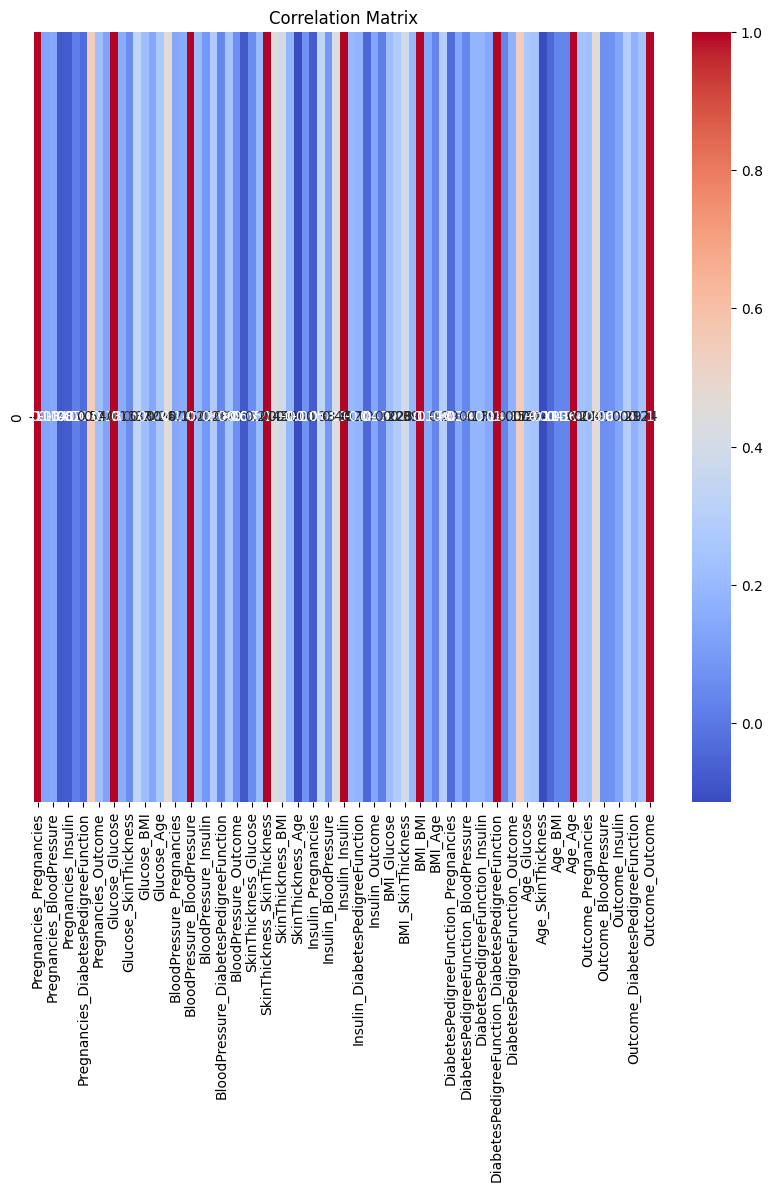

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the correlation matrix as a PySpark DataFrame
correlation_matrix = df.select([corr(col1, col2).alias(f"{col1}_{col2}") for col1 in df.columns for col2 in df.columns]).toPandas()

# Create a heatmap using Seaborn
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, ax=ax)
plt.title("Correlation Matrix")
plt.show()


In [236]:
from pyspark.sql.types import IntegerType

# Convertir les colonnes en int & float
for c in df.columns:
    if c == 'BMI' or c=='DiabetesPedigreeFunction':
        continue
    else:
        df = df.withColumn(c, col(c).cast(IntegerType()))
df = df.withColumn("BMI", col("BMI").cast("float"))
df = df.withColumn("DiabetesPedigreeFunction", col("DiabetesPedigreeFunction").cast("float"))
df.dtypes


[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'float'),
 ('DiabetesPedigreeFunction', 'float'),
 ('Age', 'int'),
 ('Outcome', 'int')]

Correlation between col1 and col2:  0.23835598302719757


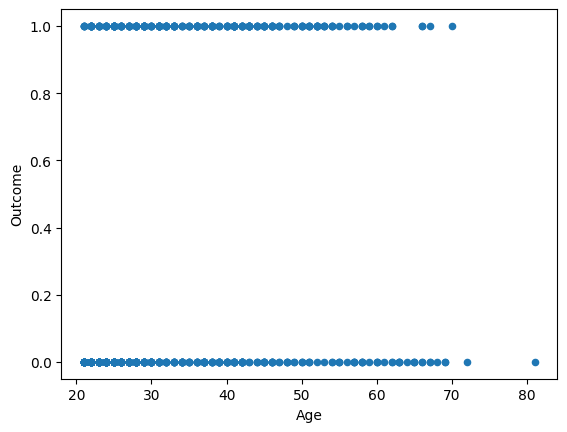

In [237]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Age', 'Outcome')

# Affichage de la corrélation
print('Correlation between Age and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('Age', 'Outcome').toPandas().plot(kind='scatter', x='Age', y='Outcome')
plt.show()


Correlation between col1 and col2:  0.22189815303398636


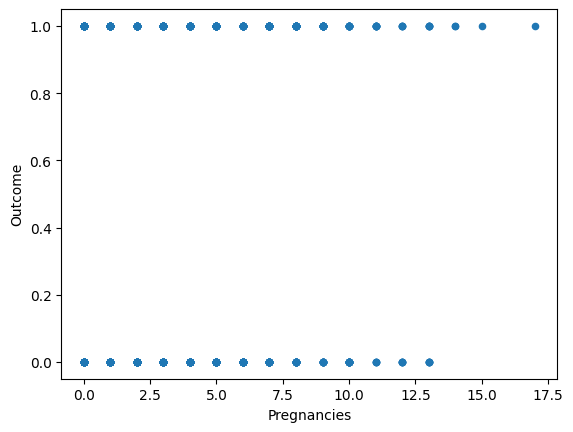

In [238]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Pregnancies', 'Outcome')

# Affichage de la corrélation
print('Correlation between Pregnancies and Outcome: ', corr_value)

# Visualisation de la corrélation
df.select('Pregnancies', 'Outcome').toPandas().plot(kind='scatter', x='Pregnancies', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.4665813983068737


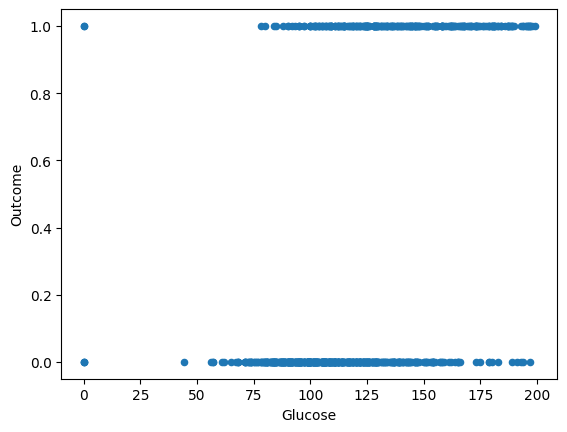

In [239]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Glucose', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('Glucose', 'Outcome').toPandas().plot(kind='scatter', x='Glucose', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.06506835955033274


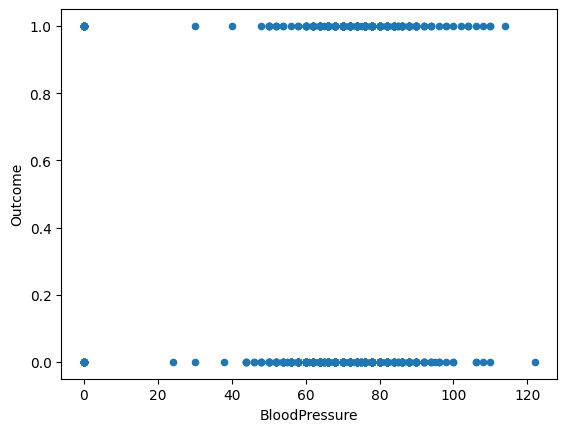

In [240]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('BloodPressure', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('BloodPressure', 'Outcome').toPandas().plot(kind='scatter', x='BloodPressure', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.07475223191831945


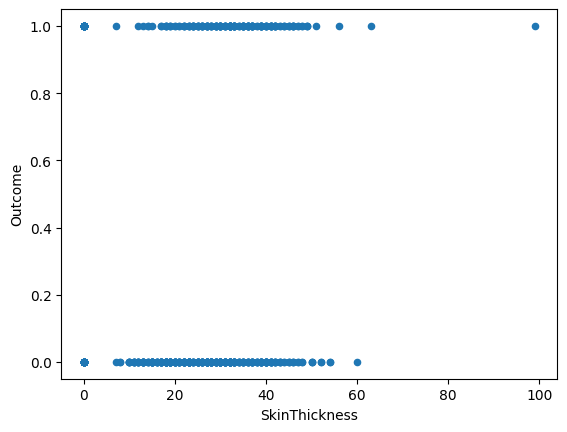

In [241]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('SkinThickness', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('SkinThickness', 'Outcome').toPandas().plot(kind='scatter', x='SkinThickness', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.13054795488404794


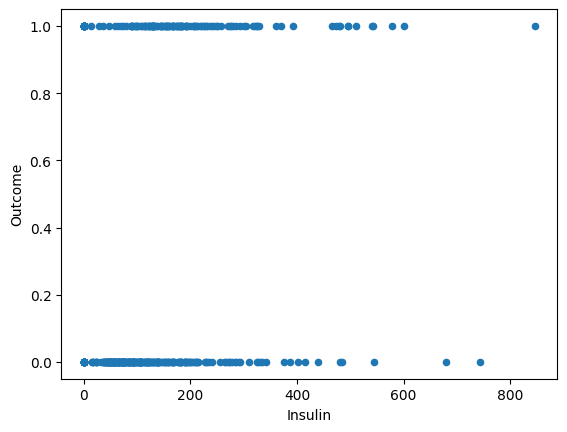

In [242]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('Insulin', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('Insulin', 'Outcome').toPandas().plot(kind='scatter', x='Insulin', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.29269466461648647


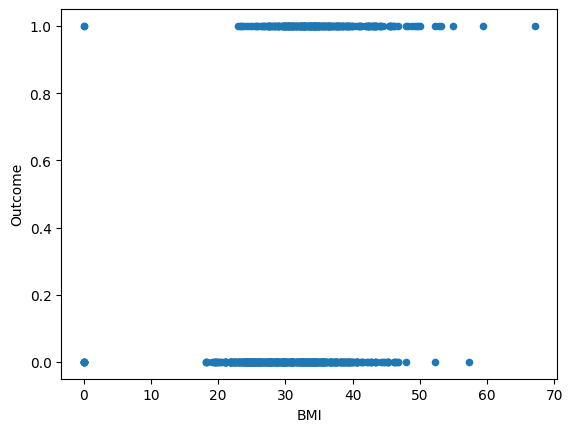

In [243]:
# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('BMI', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('BMI', 'Outcome').toPandas().plot(kind='scatter', x='BMI', y='Outcome')
plt.show()

Correlation between col1 and col2:  0.17384406790722792


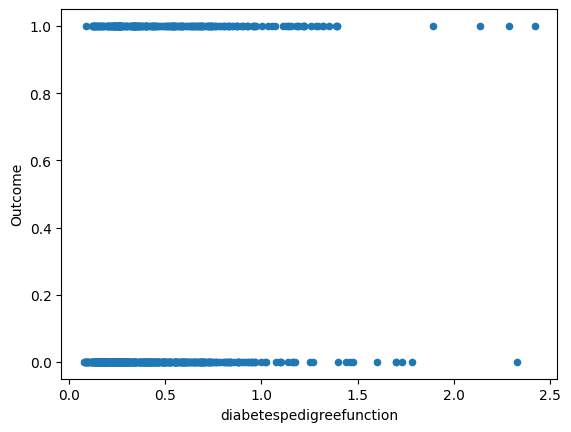

In [244]:

# Calcul de la corrélation entre les deux colonnes
corr_value = df.corr('diabetespedigreefunction', 'Outcome')

# Affichage de la corrélation
print('Correlation between col1 and col2: ', corr_value)

# Visualisation de la corrélation
df.select('diabetespedigreefunction', 'Outcome').toPandas().plot(kind='scatter', x='diabetespedigreefunction', y='Outcome')
plt.show()

In [245]:
### mahabouch yekhdmou ayast bech nekhdem bel dataframe el addeyaa choufha enty ken lkit wakt 
from pyspark_dist_explore import hist

#df.select("Age").show()
#hist(df, ["Age"])



In [246]:
import seaborn as sns

C:\Users\abidi\AppData\Local\Temp\ipykernel_16156\3731643305.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'], kde=False).set_title('age')


ValueError: setting an array element with a sequence.

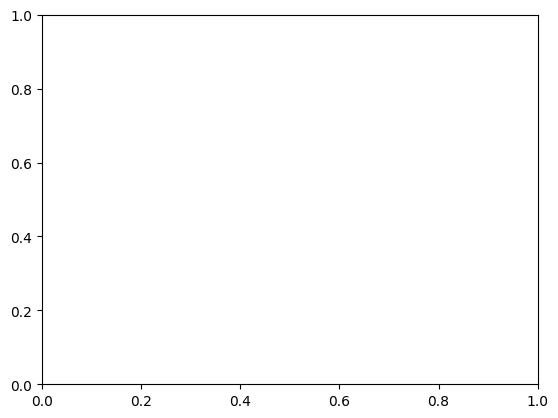

In [247]:
sns.distplot(df['Age'], kde=False).set_title('age')

C:\Users\abidi\AppData\Local\Temp\ipykernel_17884\334971594.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Pregnancies'], kde=False).set_title('Pregnancies')


Text(0.5, 1.0, 'Pregnancies')

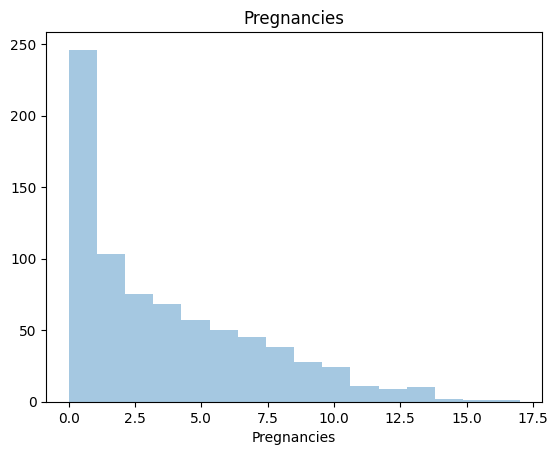

In [ ]:
sns.distplot(df['Pregnancies'], kde=False).set_title('Pregnancies')

C:\Users\abidi\AppData\Local\Temp\ipykernel_17884\2856054537.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Glucose'], kde=False).set_title('Glucose')


Text(0.5, 1.0, 'Glucose')

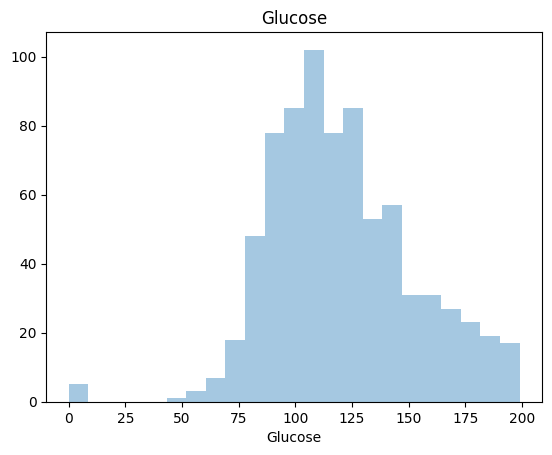

In [ ]:
sns.distplot(df['Glucose'], kde=False).set_title('Glucose')

C:\Users\abidi\AppData\Local\Temp\ipykernel_17884\3488889048.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['BloodPressure'], kde=False).set_title('BloodPressure')


Text(0.5, 1.0, 'BloodPressure')

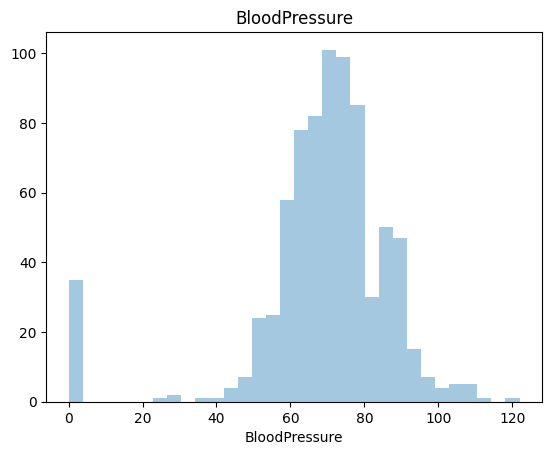

In [ ]:
sns.distplot(df['BloodPressure'], kde=False).set_title('BloodPressure')

Text(0, 0.5, 'skinth')

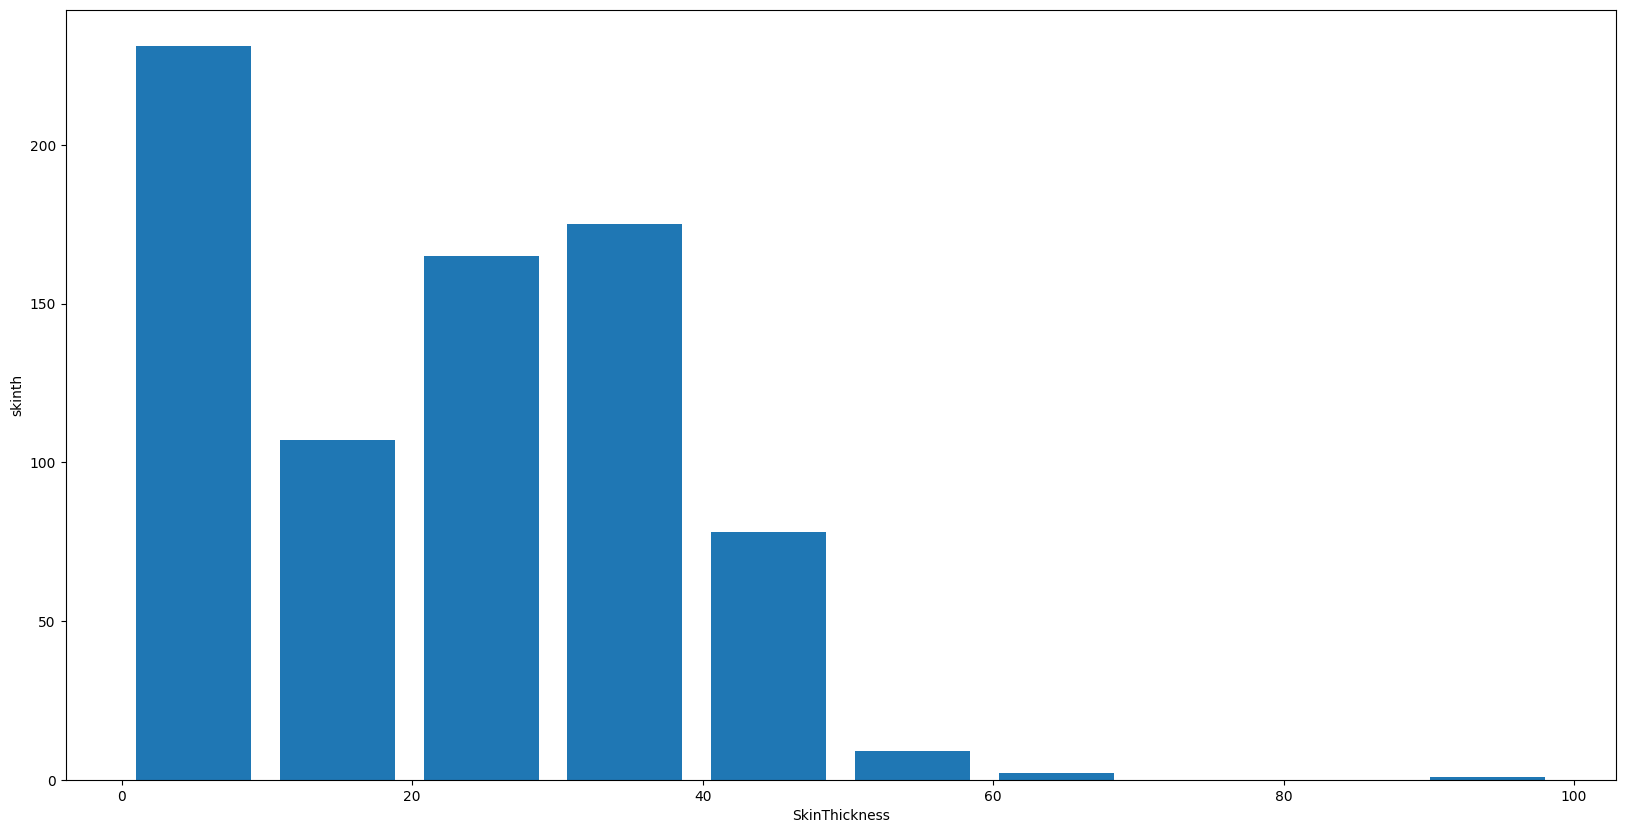

In [ ]:
plt.rcParams["figure.figsize"]=(20,10)
plt.hist(df['SkinThickness'],rwidth=0.8)
plt.xlabel("SkinThickness")
plt.ylabel("skinth")

Text(0, 0.5, 'INS')

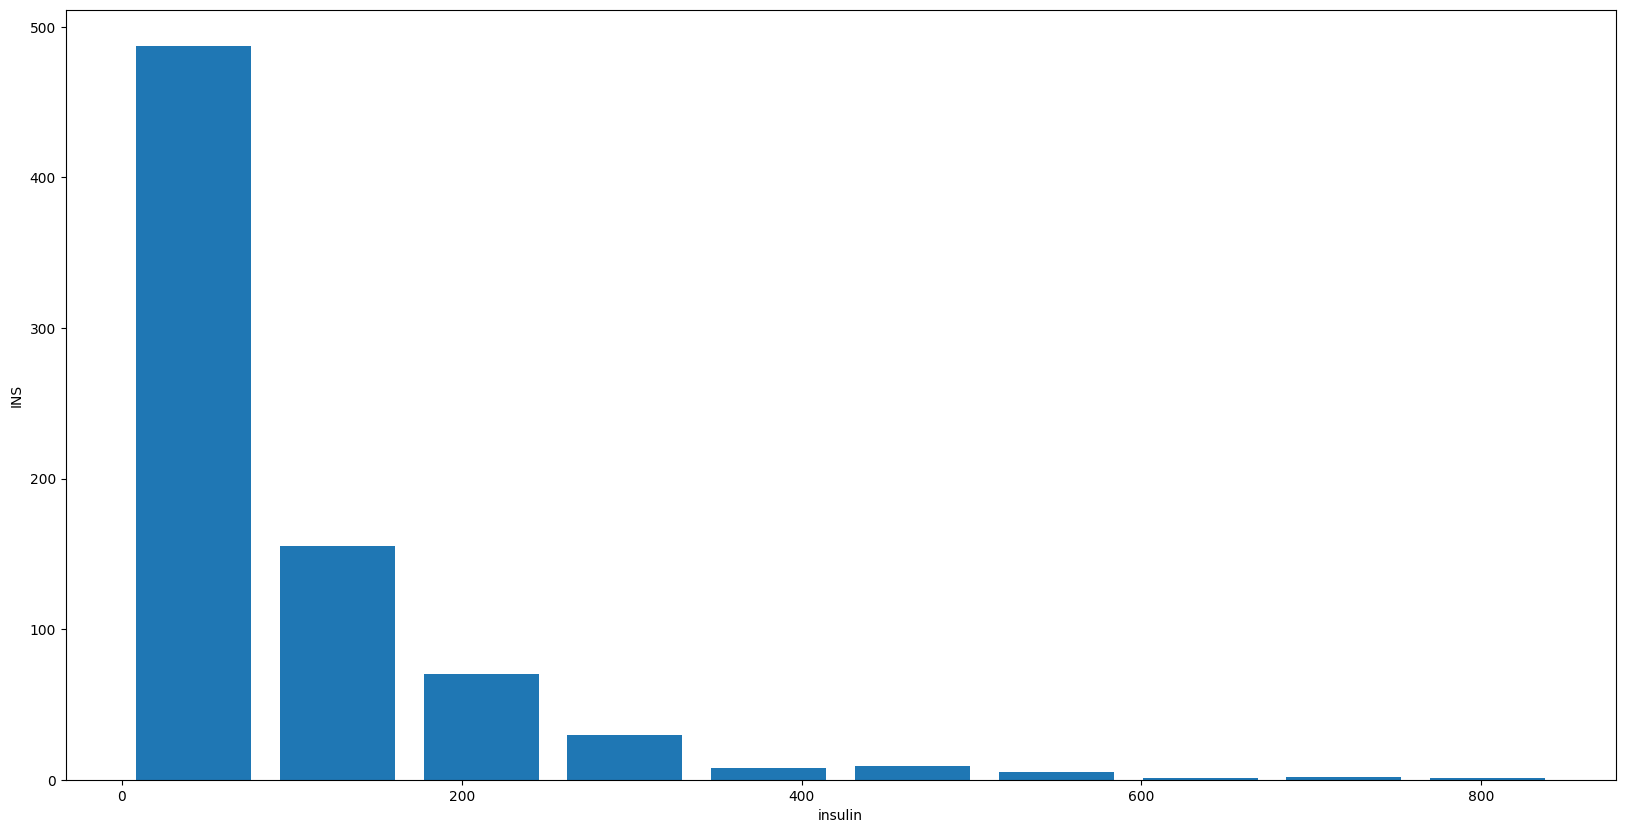

In [ ]:
plt.rcParams["figure.figsize"]=(20,10)
plt.hist(df['Insulin'],rwidth=0.8)
plt.xlabel("insulin")
plt.ylabel("INS")

In [ ]:
#partieml 
x = df.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age')
x.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+
|          6|    148|           72|           35|      0| 33|                       0| 50|
|          1|     85|           66|           29|      0| 26|                       0| 31|
|          8|    183|           64|            0|      0| 23|                       0| 32|
|          1|     89|           66|           23|     94| 28|                       0| 21|
|          0|    137|           40|           35|    168| 43|                       2| 33|
|          5|    116|           74|            0|      0| 25|                       0| 30|
|          3|     78|           50|           32|     88| 31|                       0| 26|
|         10|    115|            0|            0|      0| 35|                       0| 29|

In [ ]:
y=df.select('Outcome')

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [ ]:
input_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scaled_df = assembler.transform(df)
scaler_model = scaler.fit(scaled_df)
scaled_data = scaler_model.transform(scaled_df)

In [ ]:
scaled_data.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+--------------------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|            features|      scaledFeatures|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+--------------------+--------------------+
|          6|    148|           72|           35|      0| 33|                       0| 50|      1|[6.0,148.0,72.0,3...|[1.78063837321943...|
|          1|     85|           66|           29|      0| 26|                       0| 31|      0|[1.0,85.0,66.0,29...|[0.29677306220323...|
|          8|    183|           64|            0|      0| 23|                       0| 32|      1|[8.0,183.0,64.0,0...|[2.37418449762590...|
|          1|     89|           66|           23|     94| 28|                       0| 21|      0|[1.0,89.0,66.0,23...|[0.29677306220323...|
|          0|